In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import cv2
import yfinance as yf
from datetime import datetime, timedelta
from ultralytics import YOLO
import random
import shutil
from tqdm import tqdm
import yaml
import torch

## 2. Preparing the dataset

### 2.1 Generating candlestick chart images

In [2]:
def generate_candlestick_chart(ticker, period="2y", interval="1d", output_dir="charts"):
    """
    Generate candlestick chart images from financial data
    
    Args:
        ticker (str): Stock ticker symbol
        period (str): Data period (e.g., '2y' for 2 years)
        interval (str): Data interval (e.g., '1d' for daily)
        output_dir (str): Directory to save generated charts
    
    Returns:
        str: Path to the saved chart image
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Fetch data using yfinance
    data = yf.download(ticker, period=period, interval=interval)
    
    # Check if data is empty
    if len(data) == 0:
        print(f"No data found for {ticker}")
        return None
    
    # Create figure and axis
    fig, ax = plt.figure(figsize=(12, 8), dpi=100), plt.subplot(1, 1, 1)
    
    # Format date axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Plot candlestick chart
    width = 0.6
    width2 = 0.05
    
    # Loop through data and plot each candlestick
    for i, (idx, row) in enumerate(data.iterrows()):
        # Calculate colors based on price movement
        if row['Close'] >= row['Open']:
            color = 'green'
            body_height = row['Close'] - row['Open']
        else:
            color = 'red'
            body_height = row['Open'] - row['Close']
        
        # Plot the candlestick body
        rect = Rectangle(
            xy=(i-width/2, min(row['Open'], row['Close'])),
            width=width,
            height=body_height,
            facecolor=color,
            edgecolor='black',
            linewidth=0.5
        )
        ax.add_patch(rect)
        
        # Plot the upper and lower wicks
        ax.plot([i, i], [row['Low'], min(row['Open'], row['Close'])], color='black', linewidth=0.5)
        ax.plot([i, i], [max(row['Open'], row['Close']), row['High']], color='black', linewidth=0.5)
    
    # Set title and labels
    ax.set_title(f"{ticker} Candlestick Chart", fontsize=12)
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel("Price", fontsize=10)
    
    # Adjust the x-axis to show the most recent time period
    ax.set_xlim(-1, len(data) + 1)
    
    # Set y-axis limits with some padding
    y_min = data['Low'].min() * 0.95
    y_max = data['High'].max() * 1.05
    ax.set_ylim(y_min, y_max)
    
    # Generate a unique filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_dir, f"{ticker}_{timestamp}.jpg")
    
    # Save the chart as an image
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close(fig)
    
    return output_path

### 2.2 Generating candlestick patterns

In [3]:
def generate_pattern_dataset(tickers, patterns, num_samples_per_pattern=100, output_dir="pattern_dataset"):
    """
    Generate a dataset of candlestick patterns
    
    Args:
        tickers (list): List of stock ticker symbols
        patterns (dict): Dictionary mapping pattern names to functions that check for patterns
        num_samples_per_pattern (int): Number of samples to generate per pattern
        output_dir (str): Directory to save the dataset
    
    Returns:
        list: Paths to the generated chart images with pattern annotations
    """
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Create pattern-specific directories
    for pattern_name in patterns.keys():
        os.makedirs(os.path.join(output_dir, pattern_name), exist_ok=True)
    
    generated_charts = []
    
    # Number of patterns detected per type
    pattern_counts = {pattern_name: 0 for pattern_name in patterns.keys()}
    
    # Loop through tickers to get data
    for ticker in tqdm(tickers, desc="Processing tickers"):
        try:
            # Get longer period data to have enough patterns
            data = yf.download(ticker, period="5y", interval="1d")
            
            if len(data) < 30:  # Skip if not enough data
                continue
                
            print(f"Downloaded {len(data)} days of data for {ticker}")
            
            # Check for patterns in data
            for pattern_name, pattern_func in patterns.items():
                try:
                    pattern_signals = pattern_func(data)
                    
                    # Convert to regular Python list of indices where patterns are found
                    pattern_indices = []
                    for i in range(len(pattern_signals)):
                        if pattern_signals[i]:
                            pattern_indices.append(i)
                    
                    pattern_count = len(pattern_indices)
                    
                    print(f"Found {pattern_count} {pattern_name} patterns in {ticker}")
                    pattern_counts[pattern_name] += pattern_count
                    
                    # If patterns are found, generate images
                    if pattern_count > 0:
                        # Select random samples if there are more than needed
                        samples_per_ticker = min(
                            num_samples_per_pattern // len(tickers), 
                            len(pattern_indices)
                        )
                        samples_per_ticker = max(1, samples_per_ticker)  # Ensure at least 1 sample
                        
                        if len(pattern_indices) > samples_per_ticker:
                            pattern_indices = np.random.choice(
                                pattern_indices, 
                                size=samples_per_ticker, 
                                replace=False
                            ).tolist()
                        
                        # Generate chart for each pattern instance
                        for idx in pattern_indices:
                            # Ensure we have enough data before and after the pattern
                            if idx < 10 or idx >= len(data) - 6:
                                continue
                                
                            # Extract data window (10 candles before, pattern, 5 candles after)
                            window_data = data.iloc[idx-10:idx+6]
                            
                            # Create figure and axis with a specific figure number to avoid warnings
                            fig_num = len(generated_charts) % 20  # Reuse figure numbers to avoid too many open figures
                            plt.close(fig_num)  # Close if previously opened
                            fig = plt.figure(num=fig_num, figsize=(12, 8), dpi=100)
                            ax = fig.add_subplot(1, 1, 1)
                            
                            # Plot candlestick chart for the window
                            width = 0.6
                            
                            # Loop through window data and plot each candlestick
                            for i, (window_idx, row) in enumerate(window_data.iterrows()):
                                # Calculate colors based on price movement
                                if row['Close'] >= row['Open']:
                                    color = 'green'
                                    body_height = row['Close'] - row['Open']
                                else:
                                    color = 'red'
                                    body_height = row['Open'] - row['Close']
                                
                                # Is this candle part of the pattern? (center of the window)
                                is_pattern = False
                                
                                # Single-candle patterns
                                if pattern_name in ['doji', 'hammer', 'shooting_star'] and i == 10:
                                    is_pattern = True
                                # Two-candle patterns
                                elif pattern_name == 'engulfing' and i in [9, 10]:
                                    is_pattern = True
                                # Three-candle patterns
                                elif pattern_name in ['morning_star', 'three_white_soldiers'] and i in [8, 9, 10]:
                                    is_pattern = True
                                
                                # Plot the candlestick body
                                rect = Rectangle(
                                    xy=(i-width/2, min(row['Open'], row['Close'])),
                                    width=width,
                                    height=body_height,
                                    facecolor=color,
                                    edgecolor='black' if not is_pattern else 'blue',
                                    linewidth=0.5 if not is_pattern else 2.0
                                )
                                ax.add_patch(rect)
                                
                                # Plot the upper and lower wicks
                                ax.plot([i, i], [row['Low'], min(row['Open'], row['Close'])], 
                                       color='black' if not is_pattern else 'blue', 
                                       linewidth=0.5 if not is_pattern else 2.0)
                                ax.plot([i, i], [max(row['Open'], row['Close']), row['High']], 
                                       color='black' if not is_pattern else 'blue', 
                                       linewidth=0.5 if not is_pattern else 2.0)
                            
                            # Set y-axis limits with some padding
                            y_min = window_data['Low'].min() * 0.95
                            y_max = window_data['High'].max() * 1.05
                            ax.set_ylim(y_min, y_max)
                            
                            # Generate a unique filename
                            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                            rand_id = np.random.randint(0, 10000)
                            chart_path = os.path.join(
                                output_dir, 
                                pattern_name, 
                                f"{ticker}_{pattern_name}_{timestamp}_{rand_id}.jpg"
                            )
                            
                            # Save the chart as an image
                            plt.tight_layout()
                            plt.savefig(chart_path)
                            plt.close(fig)
                            
                            # Calculate bounding box coordinates for the pattern
                            pattern_x_center = 10  # Default for single-candle patterns
                            
                            # Depending on pattern type, set different bounding box coordinates
                            if pattern_name in ['doji', 'hammer', 'shooting_star']:
                                # Single candle patterns
                                x_min = pattern_x_center - width/2
                                x_max = pattern_x_center + width/2
                                
                                # Get the specific candle
                                candle = window_data.iloc[10]
                                
                                y_min = min(candle['Open'], candle['Close'])
                                y_max = max(candle['Open'], candle['Close'])
                                
                                # For hammer, include the lower shadow
                                if pattern_name == 'hammer':
                                    y_min = candle['Low']
                                
                                # For shooting star, include the upper shadow
                                if pattern_name == 'shooting_star':
                                    y_max = candle['High']
                                
                            elif pattern_name == 'engulfing':
                                # Two candle pattern (indices 9-10)
                                x_min = 9 - width/2
                                x_max = 10 + width/2
                                
                                # First candle
                                candle1 = window_data.iloc[9]
                                # Second candle
                                candle2 = window_data.iloc[10]
                                
                                y_min = min(candle1['Open'], candle1['Close'], candle2['Open'], candle2['Close'])
                                y_max = max(candle1['Open'], candle1['Close'], candle2['Open'], candle2['Close'])
                            
                            elif pattern_name == 'morning_star':
                                # Three candle pattern (indices 8-10)
                                x_min = 8 - width/2
                                x_max = 10 + width/2
                                
                                # Get all three candles
                                candles = window_data.iloc[8:11]
                                
                                y_min = min(candles['Low'].min(), candles['Open'].min(), candles['Close'].min())
                                y_max = max(candles['High'].max(), candles['Open'].max(), candles['Close'].max())
                            
                            elif pattern_name == 'three_white_soldiers':
                                # Three candle pattern (indices 8-10)
                                x_min = 8 - width/2
                                x_max = 10 + width/2
                                
                                # Get all three candles
                                candles = window_data.iloc[8:11]
                                
                                y_min = min(candles['Low'].min(), candles['Open'].min(), candles['Close'].min())
                                y_max = max(candles['High'].max(), candles['Open'].max(), candles['Close'].max())
                            
                            # Normalize coordinates to 0-1 range for YOLO format
                            img_width = fig.get_size_inches()[0] * fig.dpi
                            img_height = fig.get_size_inches()[1] * fig.dpi
                            
                            # Convert to YOLO format: [class_id, x_center, y_center, width, height]
                            # All values normalized to 0-1
                            class_id = list(patterns.keys()).index(pattern_name)
                            x_center = (x_min + x_max) / 2 / img_width
                            y_center = (y_min + y_max) / 2 / img_height
                            width_norm = (x_max - x_min) / img_width
                            height_norm = (y_max - y_min) / img_height
                            
                            # Create YOLO annotation file
                            annotation_path = chart_path.replace('.jpg', '.txt')
                            with open(annotation_path, 'w') as f:
                                f.write(f"{class_id} {x_center} {y_center} {width_norm} {height_norm}")
                            
                            generated_charts.append(chart_path)
                            
                            # Print out success message
                            print(f"Generated chart for {pattern_name} pattern in {ticker}")
                except Exception as e:
                    print(f"Error processing {pattern_name} pattern for {ticker}: {e}")
                    continue
                        
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
            continue
    
    # Print summary of pattern counts
    print("\nPattern detection summary:")
    for pattern_name, count in pattern_counts.items():
        print(f"{pattern_name}: {count}")
    
    return generated_charts


### 2.3 Define pattern detection functions

In [4]:
def detect_doji(data):
    """Detect Doji pattern"""
    # A doji has open and close prices that are almost equal
    body_size = abs(data['Open'] - data['Close']).values
    shadow_size = (data['High'] - data['Low']).values
    
    # Doji has very small body compared to its shadows
    # Using element-wise comparison
    doji_pattern = np.zeros(len(data), dtype=bool)
    
    for i in range(len(data)):
        # Avoid division by zero
        if shadow_size[i] > 0:
            if body_size[i] / shadow_size[i] < 0.1:
                doji_pattern[i] = True
    
    return doji_pattern

def detect_hammer(data):
    """Detect Hammer pattern"""
    hammer_pattern = np.zeros(len(data), dtype=bool)
    
    for i in range(len(data)):
        candle = data.iloc[i]
        
        # Calculate body size
        body_size = abs(candle['Open'] - candle['Close'])
        
        # Calculate lower and upper shadows
        lower_shadow = min(candle['Open'], candle['Close']) - candle['Low']
        upper_shadow = candle['High'] - max(candle['Open'], candle['Close'])
        
        # Hammer criteria:
        # 1. Lower shadow at least 2x body
        # 2. Upper shadow less than half of body
        if lower_shadow > (body_size * 2) and upper_shadow < (body_size * 0.5):
            hammer_pattern[i] = True
    
    return hammer_pattern

def detect_shooting_star(data):
    """Detect Shooting Star pattern"""
    shooting_star_pattern = np.zeros(len(data), dtype=bool)
    
    for i in range(len(data)):
        candle = data.iloc[i]
        
        # Calculate body size
        body_size = abs(candle['Open'] - candle['Close'])
        
        # Calculate lower and upper shadows
        lower_shadow = min(candle['Open'], candle['Close']) - candle['Low']
        upper_shadow = candle['High'] - max(candle['Open'], candle['Close'])
        
        # Shooting star criteria:
        # 1. Upper shadow at least 2x body
        # 2. Lower shadow less than half of body
        if upper_shadow > (body_size * 2) and lower_shadow < (body_size * 0.5):
            shooting_star_pattern[i] = True
    
    return shooting_star_pattern

def detect_engulfing(data):
    """Detect Bullish Engulfing pattern"""
    engulfing_pattern = np.zeros(len(data), dtype=bool)
    
    for i in range(1, len(data)):
        prev_candle = data.iloc[i-1]
        curr_candle = data.iloc[i]
        
        # Previous candle is bearish (red), current is bullish (green)
        prev_bearish = prev_candle['Close'] < prev_candle['Open']
        curr_bullish = curr_candle['Close'] > curr_candle['Open']
        
        # Current candle body completely engulfs previous candle body
        body_engulfing = (
            curr_candle['Open'] < prev_candle['Close'] and
            curr_candle['Close'] > prev_candle['Open']
        )
        
        if prev_bearish and curr_bullish and body_engulfing:
            engulfing_pattern[i] = True
    
    return engulfing_pattern

def detect_morning_star(data):
    """Detect Morning Star pattern (three-candle pattern)"""
    morning_star = np.zeros(len(data), dtype=bool)
    
    for i in range(2, len(data)):
        first_candle = data.iloc[i-2]
        middle_candle = data.iloc[i-1]
        last_candle = data.iloc[i]
        
        # First candle is bearish (red)
        first_bearish = first_candle['Close'] < first_candle['Open']
        
        # Middle candle is small (doji or small body)
        middle_body = abs(middle_candle['Close'] - middle_candle['Open'])
        first_body = abs(first_candle['Open'] - first_candle['Close'])
        middle_small = middle_body < (first_body * 0.3)
        
        # Last candle is bullish (green)
        last_bullish = last_candle['Close'] > last_candle['Open']
        
        # Gap down from first to middle
        gap_down = middle_candle['High'] < first_candle['Close']
        
        # Gap up from middle to last
        gap_up = last_candle['Low'] > middle_candle['High']
        
        # Last candle closes above middle point of first candle
        first_midpoint = (first_candle['Open'] + first_candle['Close']) / 2
        last_closes_high = last_candle['Close'] > first_midpoint
        
        if (first_bearish and middle_small and last_bullish and 
            (gap_down or gap_up) and last_closes_high):
            morning_star[i] = True
    
    return morning_star

def detect_three_white_soldiers(data):
    """Detect Three White Soldiers pattern"""
    three_soldiers = np.zeros(len(data), dtype=bool)
    
    for i in range(2, len(data)):
        first = data.iloc[i-2]
        second = data.iloc[i-1]
        third = data.iloc[i]
        
        # All three candles are bullish (green)
        all_bullish = (
            first['Close'] > first['Open'] and
            second['Close'] > second['Open'] and
            third['Close'] > third['Open']
        )
        
        # Each candle opens within the previous candle's body
        progressive_opens = (
            second['Open'] > first['Open'] and
            second['Open'] < first['Close'] and
            third['Open'] > second['Open'] and
            third['Open'] < second['Close']
        )
        
        # Each candle closes higher than the previous
        progressive_closes = (
            second['Close'] > first['Close'] and
            third['Close'] > second['Close']
        )
        
        if all_bullish and progressive_opens and progressive_closes:
            three_soldiers[i] = True
    
    return three_soldiers

### 2.4 Create the dataset

In [5]:
def create_dataset(output_dir="candlestick_dataset"):
    """
    Create a complete dataset for training YOLOv8
    
    Args:
        output_dir (str): Directory to save the dataset
    """
    # Define stock tickers to use (major indices, tech stocks, etc.)
    tickers = [
        "SPY", "QQQ", "DIA", "AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", 
        "NVDA", "AMD", "INTC", "JPM", "V", "MA", "DIS", "NFLX", "CSCO", "VZ",
        "T", "PFE", "MRK", "JNJ", "PG", "KO", "PEP", "WMT", "HD", "BA", "CAT"
    ]
    
    # Define patterns to detect
    patterns = {
        "doji": detect_doji,
        "hammer": detect_hammer,
        "shooting_star": detect_shooting_star,
        "engulfing": detect_engulfing,
        "morning_star": detect_morning_star,
        "three_white_soldiers": detect_three_white_soldiers
    }
    
    # Generate pattern dataset
    print("Generating pattern dataset...")
    chart_paths = generate_pattern_dataset(
        tickers=tickers,
        patterns=patterns,
        num_samples_per_pattern=300,  # 300 samples per pattern
        output_dir=os.path.join(output_dir, "raw_data")
    )
    
    # Check if any charts were generated
    if len(chart_paths) == 0:
        print("No pattern charts were generated. Please check the pattern detection logic.")
        return None
    
    # Split into train, val, test sets
    print(f"Generated {len(chart_paths)} chart images")
    
    # Shuffle paths
    random.shuffle(chart_paths)
    
    # Split: 70% train, 20% val, 10% test
    train_split = int(0.7 * len(chart_paths))
    val_split = int(0.9 * len(chart_paths))
    
    train_paths = chart_paths[:train_split]
    val_paths = chart_paths[train_split:val_split]
    test_paths = chart_paths[val_split:]
    
    # Create directories
    os.makedirs(os.path.join(output_dir, "train", "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "train", "labels"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "val", "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "val", "labels"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "test", "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "test", "labels"), exist_ok=True)
    
    # Copy files to appropriate directories
    def copy_files(paths, dest_type):
        for img_path in tqdm(paths, desc=f"Copying {dest_type} files"):
            # Copy image
            img_filename = os.path.basename(img_path)
            shutil.copy(
                img_path,
                os.path.join(output_dir, dest_type, "images", img_filename)
            )
            
            # Copy annotation
            label_path = img_path.replace(".jpg", ".txt")
            label_filename = os.path.basename(label_path)
            shutil.copy(
                label_path,
                os.path.join(output_dir, dest_type, "labels", label_filename)
            )
    
    print("Organizing dataset...")
    copy_files(train_paths, "train")
    copy_files(val_paths, "val")
    copy_files(test_paths, "test")
    
    # Create dataset YAML file
    dataset_yaml = {
        "path": os.path.abspath(output_dir),
        "train": "train/images",
        "val": "val/images",
        "test": "test/images",
        "names": list(patterns.keys())
    }
    
    with open(os.path.join(output_dir, "dataset.yaml"), "w") as f:
        yaml.dump(dataset_yaml, f)
    
    print(f"Dataset created at {output_dir}")
    print(f"Training set: {len(train_paths)} images")
    print(f"Validation set: {len(val_paths)} images")
    print(f"Test set: {len(test_paths)} images")
    
    return os.path.join(output_dir, "dataset.yaml")

## 3. Training the YOLOv8 model

In [6]:
def train_yolov8_model(dataset_yaml, model_size="n", epochs=100, batch_size=16, image_size=640):
    """
    Train a YOLOv8 model on the candlestick pattern dataset
    
    Args:
        dataset_yaml (str): Path to dataset YAML file
        model_size (str): YOLOv8 model size (n, s, m, l, x)
        epochs (int): Number of training epochs
        batch_size (int): Batch size
        image_size (int): Image size
        
    Returns:
        str: Path to the trained model weights
    """
    print(f"Training YOLOv8{model_size} model on {dataset_yaml}...")
    
    # Load a pre-trained YOLOv8 model
    model = YOLO(f"yolov8{model_size}.pt")
    
    # Train the model
    results = model.train(
        data=dataset_yaml,
        epochs=epochs,
        batch=batch_size,
        imgsz=image_size,
        patience=20,  # Early stopping patience
        save=True,
        device="0" if torch.cuda.is_available() else "cpu",
        verbose=True
    )
    
    # Get path to best model weights
    best_weights_path = model.best
    
    print(f"Training completed. Best weights saved to: {best_weights_path}")
    
    return best_weights_path

## 4. Fine-tuning the model

In [7]:
def fine_tune_model(best_weights_path, dataset_yaml, epochs=50, batch_size=8, image_size=640):
    """
    Fine-tune the YOLOv8 model
    
    Args:
        best_weights_path (str): Path to the best weights from initial training
        dataset_yaml (str): Path to dataset YAML file
        epochs (int): Number of fine-tuning epochs
        batch_size (int): Batch size
        image_size (int): Image size
        
    Returns:
        str: Path to the fine-tuned model weights
    """
    print(f"Fine-tuning model {best_weights_path}...")
    
    # Load the trained model
    model = YOLO(best_weights_path)
    
    # Fine-tune with a lower learning rate
    results = model.train(
        data=dataset_yaml,
        epochs=epochs,
        batch=batch_size,
        imgsz=image_size,
        patience=20,  # Early stopping patience
        save=True,
        device="0" if torch.cuda.is_available() else "cpu",
        verbose=True,
        lr0=0.001,  # Lower learning rate for fine-tuning
        lrf=0.01,   # Final learning rate as a fraction of initial lr
    )
    
    # Get path to best fine-tuned weights
    best_weights_path = model.best
    
    print(f"Fine-tuning completed. Best weights saved to: {best_weights_path}")
    
    return best_weights_path

## 5. Inference for pattern detection

In [8]:
def detect_patterns(chart_image_path, model_path, conf_threshold=0.25):
    """
    Detect candlestick patterns in a chart image
    
    Args:
        chart_image_path (str): Path to the chart image
        model_path (str): Path to the trained YOLOv8 model weights
        conf_threshold (float): Confidence threshold for detections
        
    Returns:
        list: List of detected patterns with confidence scores
    """
    # Load the model
    model = YOLO(model_path)
    
    # Run inference
    results = model(chart_image_path, conf=conf_threshold)
    
    # Process results
    detections = []
    
    for result in results:
        for i, (box, conf, cls) in enumerate(zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls)):
            x1, y1, x2, y2 = box.tolist()
            confidence = conf.item()
            class_id = int(cls.item())
            class_name = result.names[class_id]
            
            detections.append({
                "pattern": class_name,
                "confidence": confidence,
                "box": [x1, y1, x2, y2]
            })
    
    return detections

def visualize_detections(chart_image_path, detections, output_path=None):
    """
    Visualize detected patterns on a chart image
    
    Args:
        chart_image_path (str): Path to the chart image
        detections (list): List of detected patterns
        output_path (str, optional): Path to save the output image
        
    Returns:
        numpy.ndarray: Image with visualized detections
    """
    # Load the image
    image = cv2.imread(chart_image_path)
    
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Colors for different patterns (in RGB)
    colors = {
        "doji": (255, 0, 0),          # Red
        "hammer": (0, 255, 0),        # Green
        "shooting_star": (0, 0, 255), # Blue
        "engulfing": (255, 255, 0),   # Yellow
        "morning_star": (255, 0, 255),# Magenta
        "three_white_soldiers": (0, 255, 255) # Cyan
    }
    
    # Draw bounding boxes and labels
    for detection in detections:
        pattern = detection["pattern"]
        conf = detection["confidence"]
        box = detection["box"]
        
        # Get color for this pattern
        color = colors.get(pattern, (200, 200, 200))
        
        # Draw bounding box
        cv2.rectangle(
            image, 
            (int(box[0]), int(box[1])), 
            (int(box[2]), int(box[3])), 
            color, 
            2
        )
        
        # Prepare label text
        label = f"{pattern}: {conf:.2f}"
        
        # Get text size
        text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        
        # Calculate text background rectangle
        text_bg_x1 = int(box[0])
        text_bg_y1 = int(box[1]) - text_size[1] - 10
        text_bg_x2 = int(box[0]) + text_size[0] + 10
        text_bg_y2 = int(box[1])
        
        # Draw text background
        cv2.rectangle(
            image,
            (text_bg_x1, text_bg_y1),
            (text_bg_x2, text_bg_y2),
            color,
            -1
        )
        
        # Draw text
        cv2.putText(
            image,
            label,
            (int(box[0] + 5), int(box[1] - 5)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            2
        )
    
    # Save the output image if requested
    if output_path:
        # Convert RGB back to BGR for saving
        output_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, output_img)
    
    return image

def detect_patterns_from_ticker(ticker, model_path, period="1y", interval="1d", conf_threshold=0.3):
    """
    Generate a chart for a ticker and detect patterns
    
    Args:
        ticker (str): Stock ticker symbol
        model_path (str): Path to trained model
        period (str): Data period
        interval (str): Data interval
        conf_threshold (float): Detection confidence threshold
        
    Returns:
        tuple: (chart_path, detections, visualization)
    """
    # Generate chart
    chart_path = generate_candlestick_chart(
        ticker=ticker,
        period=period,
        interval=interval,
        output_dir="inference_charts"
    )
    
    if chart_path is None:
        return None, [], None
    
    # Detect patterns
    detections = detect_patterns(
        chart_image_path=chart_path,
        model_path=model_path,
        conf_threshold=conf_threshold
    )
    
    # Visualize detections
    output_path = chart_path.replace(".jpg", "_detected.jpg")
    visualization = visualize_detections(
        chart_image_path=chart_path,
        detections=detections,
        output_path=output_path
    )
    
    return chart_path, detections, visualization

## 6. Main execution flow

Generating pattern dataset...


Processing tickers:   0%|          | 0/30 [00:00<?, ?it/s]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing tickers:   7%|▋         | 2/30 [00:00<00:06,  4.43it/s]

Downloaded 1257 days of data for SPY
Found 115 doji patterns in SPY
Error processing doji pattern for SPY: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for SPY: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for SPY: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for SPY: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for SPY: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for SPY: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Downloaded 1257 days of data for QQQ
Found 113 doji patterns in QQQ
Error processing doj

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing tickers:  13%|█▎        | 4/30 [00:00<00:04,  5.72it/s]

Downloaded 1257 days of data for DIA
Found 122 doji patterns in DIA
Error processing doji pattern for DIA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for DIA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for DIA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for DIA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for DIA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for DIA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Downloaded 1257 days of data for AAPL
Found 132 doji patterns in AAPL
Error processing d

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing tickers:  23%|██▎       | 7/30 [00:01<00:02,  7.84it/s]

Downloaded 1257 days of data for MSFT
Found 110 doji patterns in MSFT
Error processing doji pattern for MSFT: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for MSFT: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for MSFT: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for MSFT: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for MSFT: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for MSFT: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Downloaded 1257 days of data for GOOGL
Found 132 doji patterns in GOOGL
Error pr

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing tickers:  33%|███▎      | 10/30 [00:01<00:02,  8.48it/s]

Downloaded 1257 days of data for META
Found 143 doji patterns in META
Error processing doji pattern for META: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for META: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for META: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for META: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for META: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for META: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Downloaded 1257 days of data for TSLA
Found 116 doji patterns in TSLA
Error proc

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing tickers:  40%|████      | 12/30 [00:01<00:02,  8.50it/s]

Downloaded 1257 days of data for AMD
Found 125 doji patterns in AMD
Error processing doji pattern for AMD: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for AMD: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for AMD: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for AMD: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for AMD: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for AMD: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Downloaded 1257 days of data for INTC
Found 113 doji patterns in INTC
Error processing d

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing tickers:  47%|████▋     | 14/30 [00:01<00:02,  7.96it/s]

Downloaded 1257 days of data for JPM
Found 152 doji patterns in JPM
Error processing doji pattern for JPM: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for JPM: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for JPM: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for JPM: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for JPM: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for JPM: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Downloaded 1257 days of data for V
Found 110 doji patterns in V
Error processing doji pa

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing tickers:  53%|█████▎    | 16/30 [00:02<00:01,  7.05it/s]

Downloaded 1257 days of data for MA
Found 134 doji patterns in MA
Error processing doji pattern for MA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for MA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for MA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for MA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for MA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for MA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Downloaded 1257 days of data for DIS
Found 120 doji patterns in DIS
Error processing doji patter

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing tickers:  60%|██████    | 18/30 [00:02<00:01,  7.85it/s]

Downloaded 1257 days of data for NFLX
Found 125 doji patterns in NFLX
Error processing doji pattern for NFLX: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for NFLX: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for NFLX: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for NFLX: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for NFLX: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for NFLX: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Downloaded 1257 days of data for CSCO
Found 142 doji patterns in CSCO
Error proc

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing tickers:  67%|██████▋   | 20/30 [00:02<00:01,  7.04it/s]

Downloaded 1257 days of data for VZ
Found 146 doji patterns in VZ
Error processing doji pattern for VZ: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for VZ: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for VZ: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for VZ: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for VZ: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for VZ: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Downloaded 1257 days of data for T
Found 129 doji patterns in T
Error processing doji pattern fo

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing tickers:  73%|███████▎  | 22/30 [00:03<00:01,  5.20it/s]

Downloaded 1257 days of data for PFE
Found 167 doji patterns in PFE
Error processing doji pattern for PFE: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for PFE: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for PFE: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for PFE: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for PFE: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for PFE: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Downloaded 1257 days of data for MRK
Found 141 doji patterns in MRK
Error processing doj

[*********************100%***********************]  1 of 1 completed
Processing tickers:  77%|███████▋  | 23/30 [00:03<00:01,  5.13it/s]

Downloaded 1257 days of data for JNJ
Found 138 doji patterns in JNJ
Error processing doji pattern for JNJ: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for JNJ: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for JNJ: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for JNJ: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for JNJ: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for JNJ: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Downloaded 1257 days of data for PG
Found 153 doji patterns in PG
Error processing doji pattern for PG: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for PG: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for PG: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for PG: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for PG: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for PG: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().



[*********************100%***********************]  1 of 1 completed
Processing tickers:  87%|████████▋ | 26/30 [00:04<00:00,  4.91it/s]

Downloaded 1257 days of data for KO
Found 148 doji patterns in KO
Error processing doji pattern for KO: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for KO: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for KO: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for KO: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for KO: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for KO: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Downloaded 1257 days of data for PEP
Found 143 doji patterns in PEP
Error processing doji patter

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing tickers:  93%|█████████▎| 28/30 [00:04<00:00,  5.33it/s]

Downloaded 1257 days of data for WMT
Found 123 doji patterns in WMT
Error processing doji pattern for WMT: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for WMT: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for WMT: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for WMT: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for WMT: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for WMT: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Downloaded 1257 days of data for HD
Found 121 doji patterns in HD
Error processing doji 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Processing tickers: 100%|██████████| 30/30 [00:04<00:00,  5.18it/s]

Downloaded 1257 days of data for BA
Found 126 doji patterns in BA
Error processing doji pattern for BA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing hammer pattern for BA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing shooting_star pattern for BA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing engulfing pattern for BA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing morning_star pattern for BA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Error processing three_white_soldiers pattern for BA: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Downloaded 1257 days of data for CAT
Found 123 doji patterns in CAT
Error processing doji patter

Processing tickers: 100%|██████████| 30/30 [00:04<00:00,  6.11it/s]


Pattern detection summary:
doji: 3918
hammer: 0
shooting_star: 0
engulfing: 0
morning_star: 0
three_white_soldiers: 0
No pattern charts were generated. Please check the pattern detection logic.
Dataset creation failed. Please check the pattern detection functions.


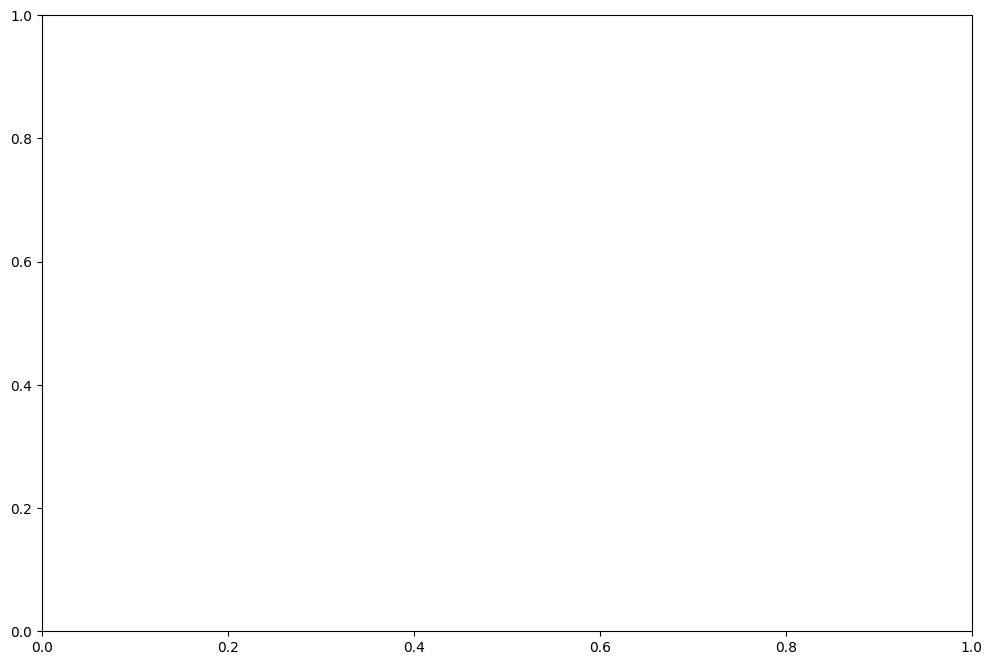

In [9]:
# 1. Create dataset
dataset_yaml = create_dataset(output_dir="candlestick_dataset")

# Check if dataset was created successfully
if dataset_yaml is None:
    print("Dataset creation failed. Please check the pattern detection functions.")

In [ ]:
# 2. Train YOLOv8 model
best_weights_path = train_yolov8_model(
    dataset_yaml=dataset_yaml,
    model_size="n",  # Start with a smaller model for faster training
    epochs=100,
    batch_size=16,
    image_size=640
)

In [ ]:
# 3. Fine-tune the model
fine_tuned_weights = fine_tune_model(
    best_weights_path=best_weights_path,
    dataset_yaml=dataset_yaml,
    epochs=50,
    batch_size=8,
    image_size=640
)

In [ ]:
 # 4. Test inference on new data
test_tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]

print("\nTesting pattern detection on new charts:")
for ticker in test_tickers:
    print(f"\nAnalyzing {ticker}...")
    chart_path, detections, viz = detect_patterns_from_ticker(
        ticker=ticker,
        model_path=fine_tuned_weights,
        period="2y",
        interval="1d",
        conf_threshold=0.3
    )
    
    if chart_path is None:
        print(f"Failed to generate chart for {ticker}")
        continue
    
    print(f"Chart saved to: {chart_path}")
    
    if len(detections) > 0:
        print(f"Detected {len(detections)} patterns:")
        for i, det in enumerate(detections):
            print(f"  {i+1}. {det['pattern']} (confidence: {det['confidence']:.2f})")
    else:
        print("No patterns detected")

print("\nModel training and testing completed!")
print(f"Trained model path: {fine_tuned_weights}")